<a href="https://colab.research.google.com/github/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim_LHCb_template_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelling the reconstructed decay angles using histogram templates

Because of imperfect knowledge due to the missing neutrino in $B_c^+ \to J/\psi \mu^+ \nu_\mu$ decays, the decay angles cannot be reconstructed with high precision. The result is that the true angular distribution, which we are interested in measuring, is distored by reconstruction and resolution effects. When attempting to fit real data, it is important to account for these effects in the fit PDF. One way to do this is through the use of histogram templates. For more detail on this approach, see [this paper](https://arxiv.org/abs/1908.04643).

In this notebook, we will look at how to employ per-event weights to make histogram templates for each of the terms in our angular decay rate. This will lead us towards fitting the reconstructed decay angles as a sum of several templates, one for each angular term (see [Bc2JpsiMuNu_RapidSim_fit.ipynb](https://github.com/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim_fit.ipynb) for a reminder of what our true angular PDF looks like).


In [1]:
!pip install uproot

     |████████████████████████████████| 301 kB 5.4 MB/s 


In [2]:
import json
import numpy as np
import uproot
import matplotlib.pyplot as plt
%matplotlib inline

Let's load the results from our fit to the truth-level angular distribution in our RapidSim MC. We will use these values to tell us what the true underlying PDF is, which will help us calculate weights for our MC to project out templates for each angular term.

In [3]:
#Load JSON file containing helicity amplitudes from our truth-level RapidSim fit
drive_dir = "/content/drive/MyDrive/Bc2JpsiMuNu_Analysis/json"
file_path = f"{drive_dir}/Bc2JspiMuNu_RapidSim_fit_results.json"
print(f"Loading JSON file {file_path}")

with open(file_path) as json_file:
    true_pars = json.load(json_file)
true_pars

Loading JSON file /content/drive/MyDrive/Bc2JpsiMuNu_Analysis/json/Bc2JspiMuNu_RapidSim_fit_results.json


{'H0_amp': [0.686267632565442, 0.002272731646289506],
 'Hm_amp': [0.6390275225936218, 0.0020177204076657624],
 'Hm_phi': [-1.531057768021171, 0.019435663977522447],
 'Hp_amp': [0.34739107913255585, 0.005825285809510019],
 'Hp_phi': [1.5603470554233514, 0.029767231502249945]}

Now we write a function to calculate the value of our true angular decay rate PDF at any point in angular phase space. We pass this function our dictionary of true helicity amplitude values, and coordinates in each angle.

In [4]:
def calc_true_model(true_pars, costheta_Jpsi, costheta_W, chi, single_term=None):
  """
  Calculate true angular decay rate at a given point in true angular phase space

    Parameters:
      true_pars -- dict of truth-level helicity amplitudes
      costheta_Jpsi -- true cos(theta_Jpsi) coordinate
      costheta_W -- true cos(theta_W) coordinate
      chi -- true chi coordinate
      single_term (optional) -- whether to return the decay rate for a single angular term
    
    Returns:
      f -- value of the decay rate 
  """
  
  H0_amp = true_pars["H0_amp"][0]
  H0_phi = 0. #fixed to 0 arbitrarily, as detailed in Bc2JpsiMuNu_RapidSim_fit.ipynb
  Hp_amp = true_pars["Hp_amp"][0]
  Hp_phi = true_pars["Hp_phi"][0]
  Hm_amp = true_pars["Hm_amp"][0]
  Hm_phi = true_pars["Hm_phi"][0]
  
  H0_re = H0_amp * np.cos(H0_phi)
  H0_im = H0_amp * np.sin(H0_phi)
  Hp_re = Hp_amp * np.cos(Hp_phi)
  Hp_im = Hp_amp * np.sin(Hp_phi)
  Hm_re = Hm_amp * np.cos(Hm_phi)
  Hm_im = Hm_amp * np.sin(Hm_phi)
  
  #complex amplitudes
  h0 = complex(H0_re,H0_im)
  hp = complex(Hp_re,Hp_im)
  hm = complex(Hm_re,Hm_im)
  h0st = complex(H0_re,-H0_im)
  hpst = complex(Hp_re,-Hp_im)
  hmst = complex(Hm_re,-Hm_im)
  hphmst = hp*hmst
  hph0st = hp*h0st
  hmh0st = hm*h0st
  
  sintheta_Jpsi = np.sqrt(1. - costheta_Jpsi * costheta_Jpsi)
  sintheta_W = np.sqrt(1. - costheta_W * costheta_W)
  sintheta_Jpsi2 = (2. * sintheta_Jpsi * costheta_Jpsi)
  sintheta_W2 = (2. * sintheta_W * costheta_W)
  coschi = np.cos(chi)
  sinchi = np.sin(chi)
  cos2chi = 2*coschi*coschi - 1
  sin2chi = 2*sinchi*coschi
  
  #3D decay rate

  #Individual angular terms
  terms = {}
  terms["0"] = sintheta_W**2 * sintheta_Jpsi**2
  terms["1"] = (1 - costheta_W)**2 * (1 + costheta_Jpsi**2)
  terms["2"] = (1 + costheta_W)**2 * (1 + costheta_Jpsi**2)
  terms["3"] = sintheta_W * sintheta_Jpsi2 * coschi * (1 - costheta_W)
  terms["4"] = sintheta_W * sintheta_Jpsi2 * coschi * (1 + costheta_W)
  terms["5"] = sintheta_W**2 * sintheta_Jpsi**2 * cos2chi

  #Total model
  if(single_term==None):
    
    f = H0_amp**2 * 2 * terms["0"]
    f += Hp_amp**2 * 0.5 * terms["1"]
    f += Hm_amp**2 * 0.5 * terms["2"]
    f += hph0st.real * terms["3"]
    f += -hmh0st.real * terms["4"]
    f += hphmst.real * terms["5"]
  
    return f
  
  else:
    
    return terms[str(single_term)]

Let's load our ROOT file of the RapidSim MC generated inside the LHCb detector acceptance. We load the file produced in our previous notebook, where we calculated the true and reconstructed decay angles.

In [5]:
#Load ROOT file containing true decay angles
drive_dir = "/content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files"
file_path = f"{drive_dir}/Bc2JpsiMuNu_RapidSim_LHCb_Vars"
print(f"Loading ROOT file {file_path}.root")
tree_name = "DecayTree"
events = uproot.open(f"{file_path}.root:{tree_name}")
events

Loading ROOT file /content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files/Bc2JpsiMuNu_RapidSim_LHCb_Vars.root


<TTree 'DecayTree' (159 branches) at 0x7f2fc922d190>

In [6]:
#Make pandas DataFrame
df = events.arrays(library="pd")

/usr/local/lib/python3.7/dist-packages/uproot/interpretation/library.py:806: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]


Now we can use our function above to calculate the true angular PDF value for every event in our DataFrame. We do this by passing the function our dictionary of the true helicity amplitudes, and also the true coordinates of each event in angular phase space (using the `_true` angles).

In [7]:
df["true_model"] = calc_true_model(true_pars, df["costheta_Jpsi_true"], df["costheta_W_true"], df["chi_true"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """Entry point for launching an IPython kernel.


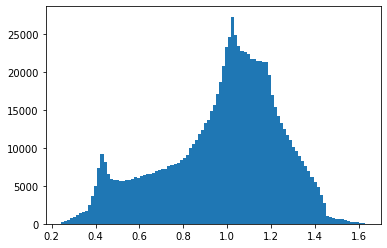

In [8]:
plt.hist(df["true_model"],bins=100)
plt.show();

Another important part of our preocedure is to calculate the values of individual angular terms in the PDF. We will take the ratio of these with our total model values above, in order to assing weights to each of our events. These weights can then be used to project out the individual angular terms from our total MC sample. This will let us make template shapes for each individual angular term.

Our function above accepts an argument `single_term`, which allows it to return the value of one term in the decay rate. We pass it a number from 0 to 5, where each number represents one of the 6 terms in our decay rate.

In [9]:
for i in range(0,6):
  df[f"single_term_{i}"] = calc_true_model(true_pars, df["costheta_Jpsi_true"], df["costheta_W_true"], df["chi_true"], single_term=i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


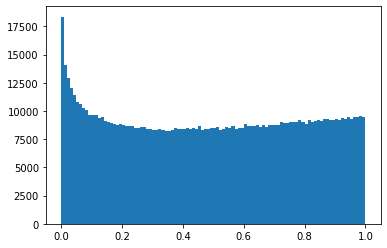

In [10]:
plt.hist(df["single_term_0"],bins=100)
plt.show();

Now we can calculate the ratios of the single angular terms relative to the total decay rate. These will act as weights, which we can use to project out template shapes for each individual angular term.

In [11]:
for i in range(0,6):
  df[f"weight_{i}"] = df[f"single_term_{i}"] / df["true_model"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


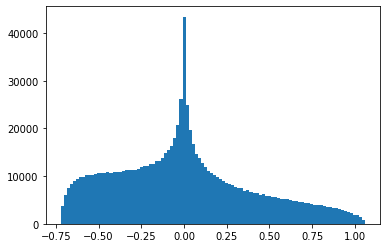

In [12]:
plt.hist(df["weight_5"],bins=100)
plt.show();

Let's see what these weights do when we apply them to our MC. We can remind ourselves what the total true $\cos(\theta_{J/\psi})$ distribution looks like first:

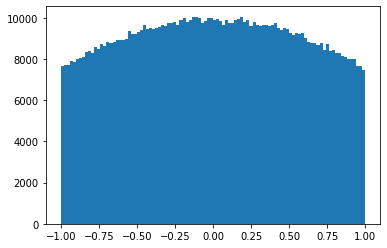

In [13]:
plt.hist(df["costheta_Jpsi_true"],bins=100)
plt.show();

And now we can plot the same angle, but with our weight for term `1` in our decay rate applied. Term `1` has angular shape $(1 - cos(\theta_W))^2 \times (1 + cos^2(\theta_{J/\psi}))$. Since $x = cos(\theta_{J/\psi})$ in our plot, we are hoping to see a $1 + x^2$ shape when we apply the term `1` weight.

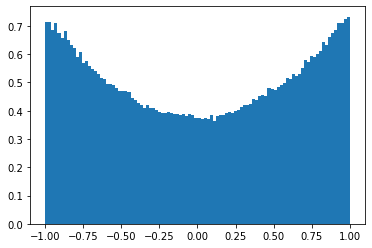

In [14]:
plt.hist(df["costheta_Jpsi_true"],bins=100, weights=df["weight_1"],density=True)
plt.show();

Awesome! We can see that the shape of the angular distribution has been changed by applying our weight for term `1`. But do we see the correct shape? 

The shape above looks like the sum of a flat line plus an $x^2$ term. And indeed, we were hoping to see a $1 + x^2$ dependence for our term `1` weight.

Importantly, we can plot any variable we want with these weights applied. We can even make histograms in more than 1 dimension, which will be important when we want to try and fit the 3D angular distribution. Let's look at the reconstructed $\cos(\theta_{J/\psi})$ plotted with the term `1` weight applied, and compare it to the true distribution.

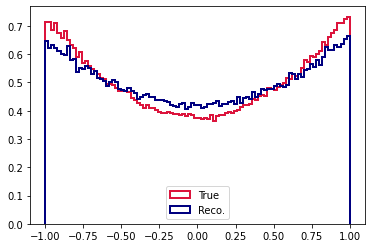

In [15]:
plt.hist(df["costheta_Jpsi_true"],bins=100, color="crimson", histtype="step", linewidth=2, weights=df["weight_1"],density=True, label="True")
plt.hist(df["costheta_Jpsi_reco"],bins=100, color="navy", histtype="step", linewidth=2, weights=df["weight_1"],density=True, label="Reco.")
plt.legend(loc="lower center")
plt.show();

This is a very important result. We can see that the reconstructed histogram also has the characteristic $1 + x^2$ shape we see in the true histogram. But the blue histogram also includes the effects of the reconstruction and resolution, which smear out the shape of the pure angular function. We can use templates like this, derived from MC, to model what the angular distribution looks like in real data. But rather than just having a single 1D histogram like this, we have:
 - 3D histograms, defined in the **reconstructed** decay angles.
 - one 3D histogram for each of the terms in our angular decay rate (we have six in total).

In such a setup, we can model the data using a sum of templates, where each template gets multiplied by its corresponding helicity amplitude term. For example, template `0` would get multiplied by $|H_0|^2$, and template `5` would get multiplied by $Re(H_+ H_-^*)$. This is the basis of the approach described in detail [here](https://arxiv.org/abs/1908.04643); in this paper, the decay $B^0 \to D^{*-} \tau^+ \nu_\tau$ is considered, which is very similar to $B_c^+ \to J/\psi \mu^+ \nu_\mu$.

Let's take a look a $\cos(\theta_W)$, which is the angle we reconstruct most poorly. We can look at term `0` as an example, which has the angular dependence $sin^2(\theta_W) \times sin^2(\theta_{J/\psi})$.

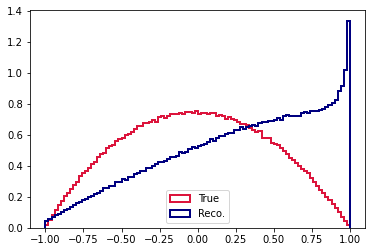

In [16]:
plt.hist(df["costheta_W_true"],bins=100, color="crimson", histtype="step", linewidth=2, weights=df["weight_0"],density=True, label="True")
plt.hist(df["costheta_W_reco"],bins=100, color="navy", histtype="step", linewidth=2, weights=df["weight_0"],density=True, label="Reco.")
plt.legend(loc="lower center")
plt.show();

When $cos(\theta_X) = 0$ in our plot, we see that our histogram is at a maximum. We know that $cos(\theta_X) = 0$ when $\theta_X = \frac{n\pi}{2}$ (where $n$ is odd). But when $\theta_X$ has such values, $\sin(\theta_X) = 1$ and thus $\sin^2(\theta_X)$ is at a maximum. When applying our term `0` weight, we expected to see a $\sin^2(\theta_X)$ dependence, and this indeed seems to be the case. You can convince yourself that the behaviour at $\cos(\theta_X) = \pm 1$ also makes sense. 

So our true histogram has the expected shape. But we can see that our reconstructed histogram has a very different shape, because of the strong effects of reconstruction and resolution which warp the true shape.

Let's save a ROOT file containing the new variables we have calculated. We will make use of our weights to build templates for each angular term, which can be used to fit the reconstructed angular distribution.

In [17]:
#Make a new file in our Google Drive, with the same name as our input file but with _Weights added to the end
out_file_path = f"{file_path}_Weights"
outfile = uproot.recreate(f"{out_file_path}.root")

In [18]:
#Add our DataFrame to the file as a TTree with the same name as our input file TTree name
#This might take a little while to run as our DataFrame is quite big
outfile[tree_name] = df

In [19]:
#Close the file to finalise things
outfile.close()